In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

In [2]:
DEVICE = 'cuda:0'

In [3]:
# A toy model with a diffuse and point source component

NN = 18

def model(z, sigma = .1, n_marg = NN):
    z_marg = np.random.rand(n_marg)
    z = np.hstack([z, z_marg])
    z = z * np.pi
    x = np.sin(z)**2
    return x

In [4]:
def noisemodel(x, z, sigma = 0.1):
    x = x + np.random.randn(*x.shape) * sigma
    return x

In [5]:
z0 = np.ones(2) * 0.25
zdim = len(z0)
comb1d = [[0], [1]]
x0 = model(z0)
print(x0, zdim)

[5.00000000e-01 5.00000000e-01 9.99592942e-01 8.97890483e-01
 4.06964526e-02 6.18075993e-01 8.89971355e-01 7.92089279e-04
 6.02672680e-01 8.15203742e-02 1.46117590e-01 1.27422206e-01
 3.67822358e-01 7.92882502e-01 1.65033199e-01 4.45427752e-03
 7.12087477e-01 4.44478492e-01 2.86594171e-02 7.27121726e-02] 2


In [6]:
# Instantiate network

ds = swyft.DataStore().init(zdim = zdim, xdim = (zdim+NN,))

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [7]:
MAX_EPOCHS = 20
NSAMPLES = 100000
Head = None

In [ ]:
td = swyft.TrainData(x0 = x0, zdim = zdim, noisehook = noisemodel, datastore = ds, nsamples = NSAMPLES)
ds.simulate(model)
re = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb1d, head = Head)
re.train(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-2, 1e-3])

Constrained posterior area: 1.0
Adding 100154 new samples. Run simulator!


Simulate: 100%|██████████| 100154/100154 [00:55<00:00, 1804.08it/s]


Start training
LR iteration 0
Total epochs: 4
LR iteration 1


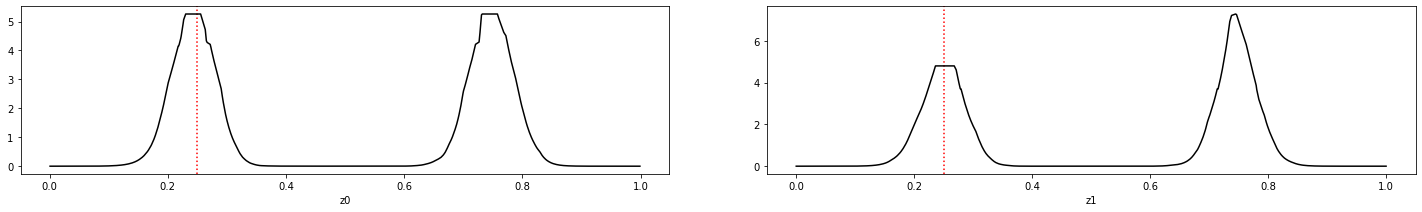

In [60]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (25, 3), ncol = 2, params = [0, 1])

In [ ]:
re2 = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = swyft.comb2d([0, 1]), head = Head)
re2.train(max_epochs = MAX_EPOCHS, nbatch = 32, early_stopping_patience = 3, lr_schedule = [1e-3, 5e-4])

In [ ]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 15, Nmax = 10000)

In [ ]:
ds = td.get_dataset()
zs = np.array([d['z'].numpy() for d in ds])
plt.scatter(zs[:,0], zs[:,1])